# ATMS 523 Final Exam
## Wenhan Tang (UIN: 678054985)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Question 1

In [2]:
# Station ID for Plant City, Florida
station_id = "USC00087205"

### Check the station info

In [3]:
df_stainfo = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt', header=None, infer_nrows=1000)
df_stainfo.columns = ['ID','LAT','LON','ELEM','TiMIN','TiMAX']
df_stainfo[ df_stainfo["ID"] == station_id ]

,ID,LAT,LON,ELEM,TiMIN,TiMAX
469143,USC00087205,28.0208,-82.1392,TMAX,1892,2025
469144,USC00087205,28.0208,-82.1392,TMIN,1892,2025
469145,USC00087205,28.0208,-82.1392,TOBS,1901,2025
469146,USC00087205,28.0208,-82.1392,PRCP,1893,2025
469147,USC00087205,28.0208,-82.1392,SNOW,1901,2025
469148,USC00087205,28.0208,-82.1392,SNWD,1901,2025
469149,USC00087205,28.0208,-82.1392,DAPR,1949,2004
469150,USC00087205,28.0208,-82.1392,MDPR,1949,2008
469151,USC00087205,28.0208,-82.1392,WT01,2008,2014
469152,USC00087205,28.0208,-82.1392,WT03,1951,2025


### Access the temperature data of selected station

In [4]:
df_sta = pd.read_parquet(
        "s3://noaa-ghcn-pds/parquet/by_station/STATION=" + station_id + "/",
        storage_options={"anon": True},
    )
df_sta["DATE"] = pd.to_datetime(df_sta["DATE"], format = "%Y%m%d")
df_sta = df_sta.set_index('DATE').sort_index()
df_sta

,ID,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME,ELEMENT
DATE,,,,,,,
1892-09-01,USC00087205,322,None,None,6,None,TMAX
1892-09-01,USC00087205,206,None,None,6,None,TMIN
1892-09-02,USC00087205,317,None,None,6,None,TMAX
1892-09-02,USC00087205,206,None,None,6,None,TMIN
1892-09-03,USC00087205,317,None,None,6,None,TMAX
...,...,...,...,...,...,...,...
2025-12-13,USC00087205,100,None,None,H,1600,TMIN
2025-12-14,USC00087205,156,None,None,H,1600,TMIN
2025-12-14,USC00087205,244,None,None,H,1600,TOBS


### Select the time period between 1991 and 2020, October - January for the daily minumum temperature

In [5]:
df_sta_date_selected = df_sta.loc[
    (df_sta.index.year >= 1991) & 
    (df_sta.index.year <= 2020) & 
    ((df_sta.index.month == 1) | 
     (df_sta.index.month == 10) | 
     (df_sta.index.month == 11) | 
     (df_sta.index.month == 12))
]
df_minT = df_sta_date_selected.loc[df_sta_date_selected['ELEMENT'] == 'TMIN']
df_minT = df_minT.assign(DATA_VALUE = df_minT["DATA_VALUE"].astype(float) / 10) # Convert to degrees Celsius
df_minT = df_minT.assign(DATA_VALUE = df_minT["DATA_VALUE"] * 9/5 + 32) # Convert to degrees Fahrenheit
df_minT

,ID,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME,ELEMENT
DATE,,,,,,,
1991-01-01,USC00087205,62.06,None,None,0,1800,TMIN
1991-01-02,USC00087205,64.94,None,None,0,1800,TMIN
1991-01-03,USC00087205,64.04,None,None,0,1800,TMIN
1991-01-04,USC00087205,64.04,None,None,0,1800,TMIN
1991-01-05,USC00087205,62.96,None,None,0,1800,TMIN
...,...,...,...,...,...,...,...
2020-12-27,USC00087205,33.98,None,None,7,1600,TMIN
2020-12-28,USC00087205,48.02,None,None,7,1600,TMIN
2020-12-29,USC00087205,53.06,None,None,7,1600,TMIN


### Calculate whether a day have the risk of frost and freeze (for each day)

In [6]:
df_frost_freeze = pd.DataFrame(index=df_minT.index)

df_frost_freeze["is_frost"] = np.where(df_minT["DATA_VALUE"] <= 32, 1, 0)
df_frost_freeze["is_freeze"] = np.where(df_minT["DATA_VALUE"] <= 28, 1, 0)
df_frost_freeze

,is_frost,is_freeze
DATE,,
1991-01-01,0,0
1991-01-02,0,0
1991-01-03,0,0
1991-01-04,0,0
1991-01-05,0,0
...,...,...
2020-12-27,0,0
2020-12-28,0,0
2020-12-29,0,0


### Calculate the total number of days that have the risk of frost and freeze (for each month)

In [7]:
df_dangeous_monthly = (
    df_frost_freeze.groupby(
        df_frost_freeze.index.to_period("M")
    ).sum()
)
df_dangeous_monthly = df_dangeous_monthly.rename(columns={
    "is_frost": "num_frost_days",
    "is_freeze": "num_freeze_days"
})
df_dangeous_monthly

,num_frost_days,num_freeze_days
DATE,,
1991-01,0,0
1991-10,0,0
1991-11,0,0
1991-12,0,0
1992-01,3,0
...,...,...
2019-12,0,0
2020-01,1,0
2020-10,0,0


### Calculate the risk of frost and freeze for Jan, Oct, Nov, and Dec, which concludes the answer of question 1.

In [8]:
df_dangeous_month = df_dangeous_monthly.groupby(df_dangeous_monthly.index.month).mean()
df_dangeous_month.index.name = "MONTH"
df_dangeous_month

,num_frost_days,num_freeze_days
MONTH,,
1,1.866667,0.500000
10,0.000000,0.000000
11,0.033333,0.000000
12,0.600000,0.166667


## Question 2

### Access the NINO indices and SST data

In [9]:
df_nino_orig = pd.read_csv(
    "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices",
    delim_whitespace=True,
)
df_nino_orig = df_nino_orig.loc[
    (df_nino_orig["YR"] >= 1991) & 
    (df_nino_orig["YR"] <= 2020) & 
    ((df_nino_orig["MON"] == 1) | 
     (df_nino_orig["MON"] == 10) | 
     (df_nino_orig["MON"] == 11) | 
     (df_nino_orig["MON"] == 12))
]

df_nino_orig["DATE"] = pd.to_datetime(
    df_nino_orig["YR"].astype(str) + "-" + df_nino_orig["MON"].astype(str),
    format="%Y-%m"
)


/var/folders/4v/xs1f8bws5vj6gd4p9n0gl_6h0000gr/T/ipykernel_35245/2156501495.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nino_orig = pd.read_csv(


### First, consider the NINO indices as the predictors, extract the NINO indices

In [10]:
df_nino = df_nino_orig.set_index(df_nino_orig["DATE"].dt.to_period("M"))
df_nino = df_nino[ ["NINO1+2", "NINO3", "NINO4", "NINO3.4"] ]
df_nino

,NINO1+2,NINO3,NINO4,NINO3.4
DATE,,,,
1991-01,23.73,25.63,28.62,26.89
1991-10,21.09,25.36,29.31,27.41
1991-11,21.92,25.93,29.12,27.71
1991-12,23.13,26.30,29.21,28.14
1992-01,24.59,26.86,28.80,28.23
...,...,...,...,...
2019-12,23.11,25.56,29.29,27.08
2020-01,24.49,25.89,29.16,27.08
2020-10,20.12,24.19,27.97,25.64


In [11]:
df_merged = pd.merge(df_dangeous_monthly["num_freeze_days"], df_nino, left_index=True, right_index=True, how="outer")
df_merged

,num_freeze_days,NINO1+2,NINO3,NINO4,NINO3.4
DATE,,,,,
1991-01,0,23.73,25.63,28.62,26.89
1991-10,0,21.09,25.36,29.31,27.41
1991-11,0,21.92,25.93,29.12,27.71
1991-12,0,23.13,26.30,29.21,28.14
1992-01,0,24.59,26.86,28.80,28.23
...,...,...,...,...,...
2019-12,0,23.11,25.56,29.29,27.08
2020-01,0,24.49,25.89,29.16,27.08
2020-10,0,20.12,24.19,27.97,25.64


### Calculate the Pearson's correlation coefficient between the risk of freeze and NINO indices

In [12]:
corr = df_merged.corr()
corr_freeze_nino = corr["num_freeze_days"].drop("num_freeze_days")
corr_freeze_nino_abs = abs(corr_freeze_nino)
corr_freeze_nino

NINO1+2    0.179884
NINO3     -0.052943
NINO4     -0.211082
NINO3.4   -0.141503
Name: num_freeze_days, dtype: float64

Text(0, 0.5, 'Correlation coefficient')

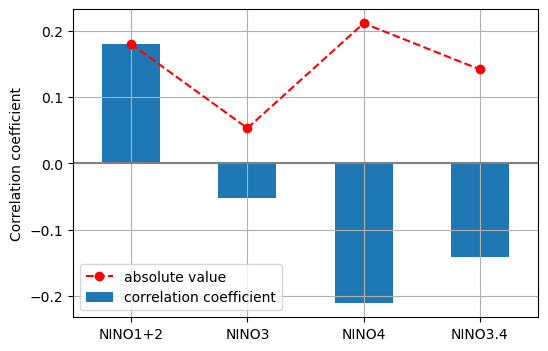

In [13]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(1, 1, 1)

corr_freeze_nino.plot(kind = "bar", ax = ax, label = "correlation coefficient")
corr_freeze_nino_abs.plot(ax = ax, linestyle = "--", marker = "o", color = "red", label = "absolute value")
ax.axhline(0, color = "gray")
ax.grid()
ax.legend()
ax.set_ylabel("Correlation coefficient")

### Answer for question 2 (part1):
The NINO4 index shows the strongest absolute correlation with the number of freeze-risk days, followed by NINO1+2 and NINO3.4, while NINO3 exhibits the weakest relationship.

### Next, consider the SST (detrended and standardized) as the predictor, extract the SST anomaly data for each NINO region

In [14]:
df_sst =  df_nino_orig.set_index(df_nino_orig["DATE"].dt.to_period("M"))
df_sst = df_sst[ ["ANOM", "ANOM.1", "ANOM.2", "ANOM.3"] ]
df_sst = df_sst.rename(columns = {
    "ANOM": "SST_1+2",
    "ANOM.1": "SST_3",
    "ANOM.2": "SST_4",
    "ANOM.3": "SST_3.4",
})
df_sst

,SST_1+2,SST_3,SST_4,SST_3.4
DATE,,,,
1991-01,-0.78,-0.05,0.40,0.33
1991-10,0.22,0.27,0.63,0.64
1991-11,0.29,0.73,0.44,0.89
1991-12,0.29,1.03,0.77,1.50
1992-01,0.07,1.18,0.58,1.67
...,...,...,...,...
2019-12,0.27,0.29,0.85,0.44
2020-01,-0.03,0.22,0.94,0.52
2020-10,-0.76,-0.90,-0.71,-1.13


### Define the function of linear detrend and standardize (adapted from Module 4)

In [15]:
def _time_as_float(time):
    return (time - time[0]).astype("timedelta64[s]").astype("int64").astype("float64").to_numpy()
    
def linear_detrend(df_sst):
    t = _time_as_float(df_sst.index.to_timestamp())

    def _trend(sst):
        t_mean = t.mean()
        tc = t - t_mean
        num = (sst * tc).sum()
        den = (tc**2).sum()
        slope = np.where(den > 0, num / den, 0.0)

        ybar  = sst.mean()
        trend = slope * (t - t_mean) + ybar
        return trend
        
    def _detrend_da(sst):
        trend = _trend(sst)
        return (sst - trend).astype("float32")
        
    return df_sst.apply(_detrend_da)

def monthly_anom_and_z(
    df_sst_detr,
    ddof: int = 1,
    eps: float = 1e-6,
):
    key = df_sst_detr.index.to_timestamp().month

    clim_mean = df_sst_detr.groupby(key).mean()
    anom = df_sst_detr.groupby(key).transform(lambda x: x - x.mean())

    clim_std = df_sst_detr.groupby(key).std(ddof=ddof)
    safe_std = clim_std.where(clim_std > eps, np.nan)
    z = df_sst_detr.groupby(key).transform(lambda x: (x - x.mean()) / (x.std(ddof=ddof) if x.std(ddof=ddof) > eps else np.nan))
    return anom, z, clim_mean, safe_std

### Detrended SST data for each NINO region

In [16]:
df_sst_detr = linear_detrend(df_sst)
df_sst_detr

,SST_1+2,SST_3,SST_4,SST_3.4
DATE,,,,
1991-01,-0.856385,-0.015727,0.552109,0.333069
1991-10,0.147394,0.302550,0.774584,0.642896
1991-11,0.217823,0.762354,0.583729,0.892877
1991-12,0.218238,1.062165,0.912902,1.502858
1992-01,-0.001333,1.211970,0.722048,1.672838
...,...,...,...,...
2019-12,0.339806,0.257636,0.710992,0.436405
2020-01,0.040235,0.187440,0.800137,0.516386
2020-10,-0.685972,-0.934289,-0.857416,-1.133787


### Standardized SST data for each NINO region

In [17]:
df_anom, df_z, df_clim_mean, df_safe_std = monthly_anom_and_z(df_sst_detr)
df_z

,SST_1+2,SST_3,SST_4,SST_3.4
DATE,,,,
1991-01,-1.097854,-0.015622,0.685761,0.309218
1991-10,0.134449,0.317772,1.178120,0.694763
1991-11,0.189760,0.673319,0.751993,0.815923
1991-12,0.200457,0.905518,1.137784,1.329907
1992-01,0.002238,1.164729,0.898812,1.550789
...,...,...,...,...
2019-12,0.313268,0.220449,0.886803,0.385859
2020-01,0.055718,0.179710,0.996712,0.479099
2020-10,-0.619136,-0.983291,-1.300640,-1.224923


### Calculate the Pearson's correlation coefficient between the risk of freeze and standardized SST

In [18]:
df_merged_sst = pd.merge(df_dangeous_monthly["num_freeze_days"], df_z, left_index=True, right_index=True, how="outer")
corr = df_merged_sst.corr()
corr_freeze_sstz = corr["num_freeze_days"].drop("num_freeze_days")
corr_freeze_sstz_abs = abs(corr_freeze_sstz)
corr_freeze_sstz

SST_1+2   -0.155370
SST_3     -0.118430
SST_4     -0.129209
SST_3.4   -0.106978
Name: num_freeze_days, dtype: float64

Text(0, 0.5, 'Correlation coefficient')

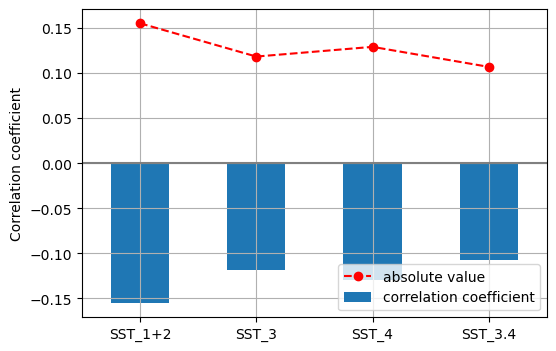

In [19]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(1, 1, 1)

corr_freeze_sstz.plot(kind = "bar", ax = ax, label = "correlation coefficient")
corr_freeze_sstz_abs.plot(ax = ax, linestyle = "--", marker = "o", color = "red", label = "absolute value")
ax.axhline(0, color = "gray")
ax.grid()
ax.legend()
ax.set_ylabel("Correlation coefficient")

### Answer for question 2 (part2):
he SST in the NINO1+2 region shows the strongest absolute correlation with the number of freeze-risk days, followed by that in the NINO4 region, while the SST in NINO3 and NINO3.4 exhibits the weakest relationships.

Overall, although the results are not identical between using the NINO indices directly and using the standardized SST as predictors of freeze risk in Plant City, Florida, we can conclude that SST anomalies in the NINO4 and NINO1+2 regions are more strongly associated with cold conditions in central Florida than those in the NINO3 and NINO3.4 regions.